In [16]:
import seaborn as sns

import json

base = 'INSERT_BASE_PATH'
train_data_dir = base + 'train/images/'
val_data_dir = base + 'val/images/'
test_data_dir = base + 'test/images/'

train_annotation = base + 'annotations/instances_train.json'
val_annotation = base + 'annotations/instances_val.json'
test_annotation = base +  'annotations/instances_test_nogt.json'

# Valid Metadata

In [25]:
def analysis(data):
    valid, not_valid = 0, 0

    for image in data['images']:
        if image['meta'] != None: valid += 1
        else: not_valid += 1
        
    return valid, not_valid

print(f"Train Data (valid / invalid): {analysis(json.load(open(train_annotation, 'r')))}")
print(f"Validation Data (valid / invalid): {analysis(json.load(open(val_annotation, 'r')))}")
print(f"Test Data (valid / invalid): {analysis(json.load(open(test_annotation, 'r')))}")

Train Data (valid / invalid): (6212, 2718)
Validation Data (valid / invalid): (1093, 454)
Test Data (valid / invalid): (2692, 1058)


# Image Ratios

In [20]:

from PIL import Image
import os
import statistics

def image_ratio(folder_path):
    ratios = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img = Image.open(os.path.join(folder_path, filename))
            width, height = img.size
            aspect_ratio = width / height
            ratios.append(aspect_ratio)

    median_ratio = statistics.median(ratios)
    mean_ratio = statistics.mean(ratios)
    mode_ratio = statistics.mode(ratios)

    print("Median ratio:", median_ratio)
    print("Mean ratio:", mean_ratio)
    print("Mode ratio:", mode_ratio)

print("Train: ")
image_ratio(train_data_dir) 
print("\nValidation: ")
image_ratio(val_data_dir)
print("\nTest: ")
image_ratio(test_data_dir)

Train: 
Median ratio: 1.7777777777777777
Mean ratio: 1.7473172528802932
Mode ratio: 1.7777777777777777

Validation: 
Median ratio: 1.7777777777777777
Mean ratio: 1.7513119488414808
Mode ratio: 1.7777777777777777

Test: 
Median ratio: 1.7777777777777777
Mean ratio: 1.6725377948250313
Mode ratio: 1.7777777777777777


# Load Data

In [21]:
def normalize(x_coco, y_coco, w_coco, h_coco, w_img, h_img):
    x_yolo = x_coco/w_img
    y_yolo = y_coco/h_img
    w_yolo = w_coco/w_img
    h_yolo = h_coco/h_img
    return [x_yolo, y_yolo, w_yolo, h_yolo]

def data_loader(annotations_file):
    data = json.load(open(annotations_file, 'r'))

    # Add overhead at creation to allow O(1) arraccess
    annotations = {image['id']: image for image in data['images']} 
    position_id = [image['id'] for image in data['images']]

    annotations_bbox = {}
    for key in data['annotations']:
        w_img = annotations[key['image_id']]['width']
        h_img = annotations[key['image_id']]['height']

        if key['image_id'] not in annotations_bbox:
            annotations_bbox[key['image_id']] = []
        annotations_bbox[key['image_id']].append([key['category_id'], normalize(key['bbox'][0], key['bbox'][1], key['bbox'][2], key['bbox'][3], w_img, h_img)])

    return data, annotations_bbox

In [3]:
train, bboxtrain = data_loader(train_annotation)
test, bboxtest = data_loader(test_annotation)
val, bboxval = data_loader(val_annotation)

In [24]:
def analysis(data):
    meta_dict = {}

    angle = []
    height_list = []
    time = []
    time2 = []
    for image in data['images']:
        if image['meta'] != None: 
            if ('height_above_takeoff(meter)' in image['meta']):
                time.append(image['meta']['datetime(utc)'])
                angle.append(int(image['meta']['gimbal_pitch(degrees)']))
                height_list.append(int(image['meta']['height_above_takeoff(meter)']))
            elif ('altitude' in image['meta']):
                time2.append(image['meta']['date_time'])
                angle.append(int(image['meta']['gimbal_pitch']))
                height_list.append(int(image['meta']['altitude']))

    return meta_dict, height_list, angle, time, time2

meta_dict_train, height_list_train, angle_list_train, time_list_train, time2_list_train = analysis(train) 
meta_dict_val, height_list_val, angle_list_val, time_list_val, time2_list_val = analysis(val)
meta_dict_test, height_list_test, angle_list_test, time_list_test, time2_list_test = analysis(test)

# Metadata Plots

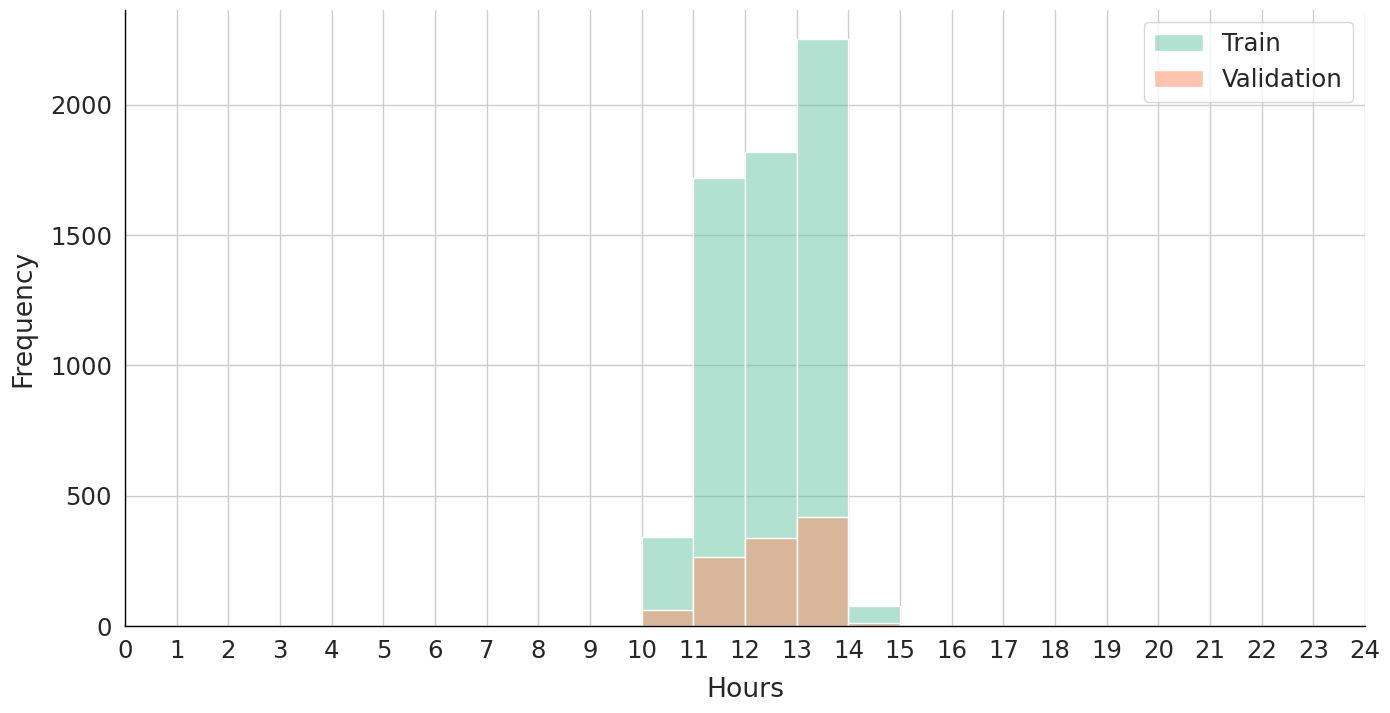

In [26]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def extract_hours_from_list(date_list):
    hours_list = []
    for date_string in date_list:
        
        if 'T' in date_string:
            datetime_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S')
        else:
            datetime_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
        hours = datetime_obj.hour
        hours_list.append(hours)
    return hours_list

hours_list_train = extract_hours_from_list(time_list_train) + extract_hours_from_list(time2_list_train)
hours_list_val = extract_hours_from_list(time_list_val) + extract_hours_from_list(time2_list_val)


sns.set(style="whitegrid", font_scale=1.6, rc={"axes.edgecolor": "black", "axes.linewidth": 1})
sns.set_palette("Set2")  # Array of colors

_, ax = plt.subplots(figsize=(16, 8))

# Define the bin edges from 0 to 24 (inclusive)
bin_edges = [i for i in range(0, 25)]

sns.histplot(hours_list_train, bins=bin_edges, alpha=0.5, label='Train')
sns.histplot(hours_list_val, bins=bin_edges, alpha=0.5, label='Validation')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Set x-axis tick frequency to 1
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))  # Set x-axis minor tick frequency to 0.5

# Remove -1 and 25 from the x-axis
ax.set_xlim(0, 24)

ax.set_xlabel("Hours", labelpad=10)
ax.set_ylabel("Frequency", labelpad=10)

ax.legend()  # Add legend to differentiate between train and test

sns.despine()  # Remove the top and right spines
#plt.savefig('./hours_histogram.png', dpi=400)
plt.show()


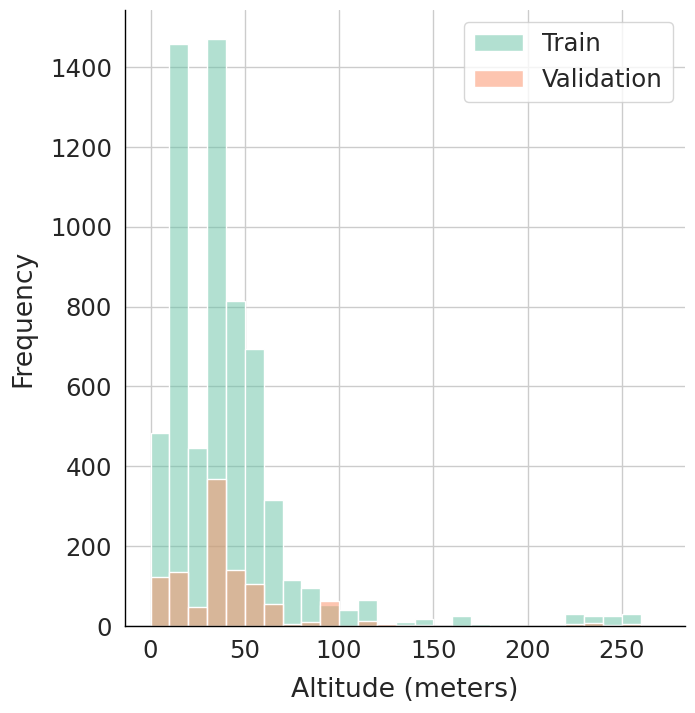

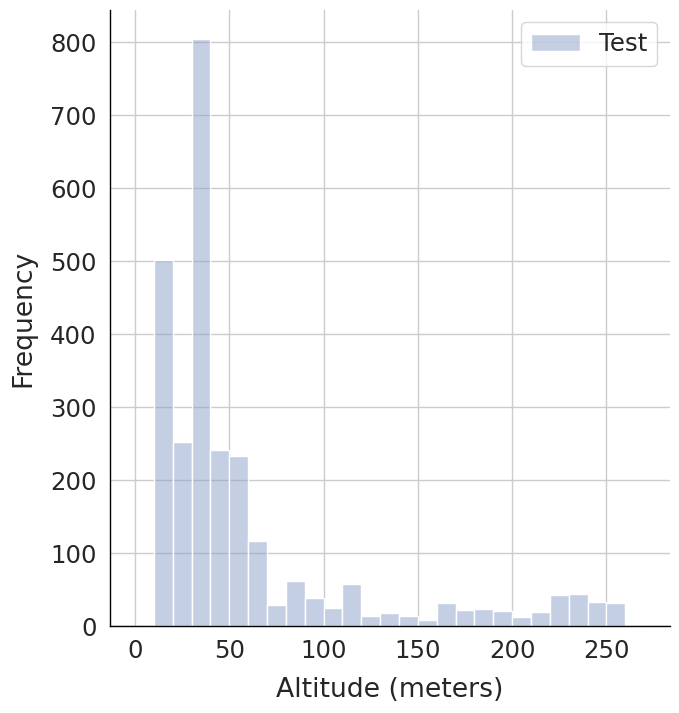

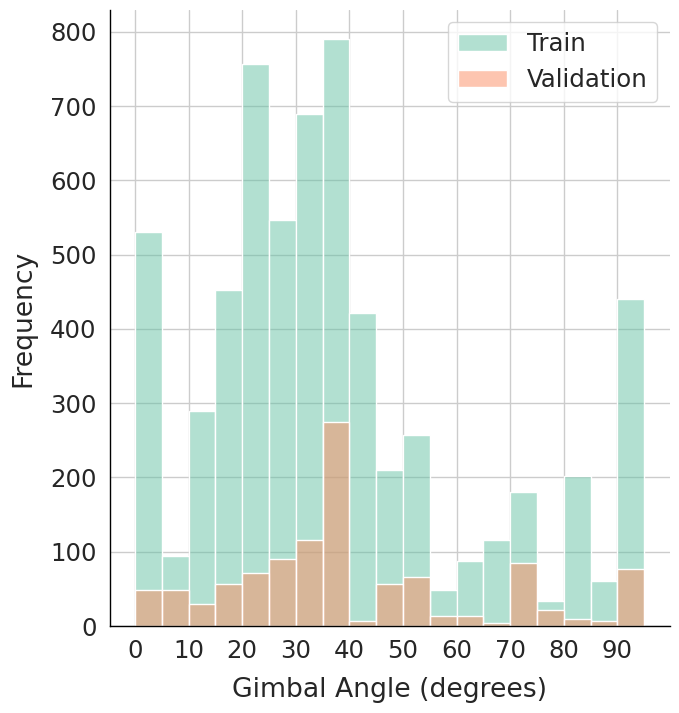

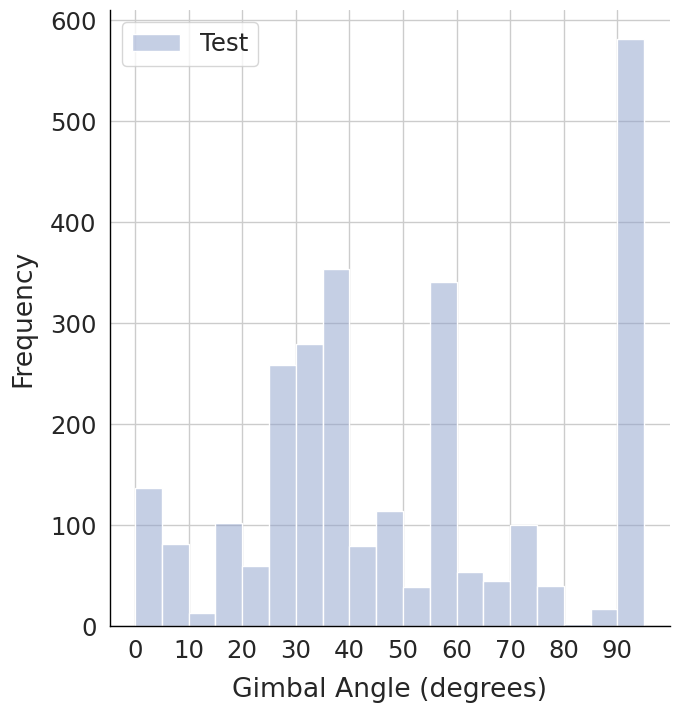

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

## Altitude Train Val
sns.set(style="whitegrid", font_scale=1.6, rc={"axes.edgecolor": "black", "axes.linewidth": 1})
sns.set_palette("Set2") # Arrayzinho de cores

_, ax = plt.subplots(figsize=(8, 8))

bin_edges = [i for i in range(0, 275, 10)]  # Define the bin edges

sns.histplot(height_list_train, bins=bin_edges, alpha=0.5, label='Train')
sns.histplot(height_list_val, bins=bin_edges, alpha=0.5, label='Validation')


ax.xaxis.grid(True)
ax.set_xlabel("Altitude (meters)", labelpad=10)


ax.set_ylabel("Frequency", labelpad=10)
ax.legend()  # Add legend to differentiate between train and test

sns.despine()  # Remove the top and right spines
plt.subplots_adjust(left=0.2)
#plt.savefig('./altitude-trainval.png', dpi=400)
plt.show()

## Altitude Test
sns.set(style="whitegrid", font_scale=1.6, rc={"axes.edgecolor": "black", "axes.linewidth": 1})
sns.set_palette("Set2") # Arrayzinho de cores

_, ax = plt.subplots(figsize=(8, 8))

bin_edges = [i for i in range(0, 275, 10)]  # Define the bin edges

sns.histplot(height_list_test, bins=bin_edges, alpha=0.5, label='Test', color=sns.color_palette()[2])

ax.xaxis.grid(True)
ax.set_xlabel("Altitude (meters)", labelpad=10)


ax.set_ylabel("Frequency", labelpad=10)
ax.legend()  # Add legend to differentiate between train and test
sns.despine()  # Remove the top and right spines
plt.subplots_adjust(left=0.2)
#plt.savefig('./altitude-test.png', dpi=400)
plt.show()

## Angle Train Val
_, ax = plt.subplots(figsize=(8, 8))

bin_edges = [i for i in range(0, 100, 5)]  # Define the bin edges
sns.histplot(angle_list_train, bins=bin_edges, alpha=0.5, label='Train')
sns.histplot(angle_list_val, bins=bin_edges, alpha=0.5, label='Validation')
sns.despine()  # Remove the top and right spines
ax.set_xlabel("Gimbal Angle (degrees)", labelpad=10)
ax.set_ylabel("Frequency", labelpad=10)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.grid(True)
ax.legend()  # Add legend to differentiate between train and test
plt.subplots_adjust(left=0.2)
#plt.savefig('./angle-trainval.png', dpi=400)
plt.show()

## Angle Test
_, ax = plt.subplots(figsize=(8, 8))

bin_edges = [i for i in range(0, 100, 5)]  # Define the bin edges
sns.histplot(angle_list_test, bins=bin_edges, alpha=0.5, color=sns.color_palette()[2], label='Test')
sns.despine()  # Remove the top and right spines
ax.set_xlabel("Gimbal Angle (degrees)", labelpad=10)
ax.set_ylabel("Frequency", labelpad=10)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.grid(True)
ax.legend()  # Add legend to differentiate between train and test
plt.subplots_adjust(left=0.2)
#plt.savefig('./angle-test.png', dpi=400)
plt.show()

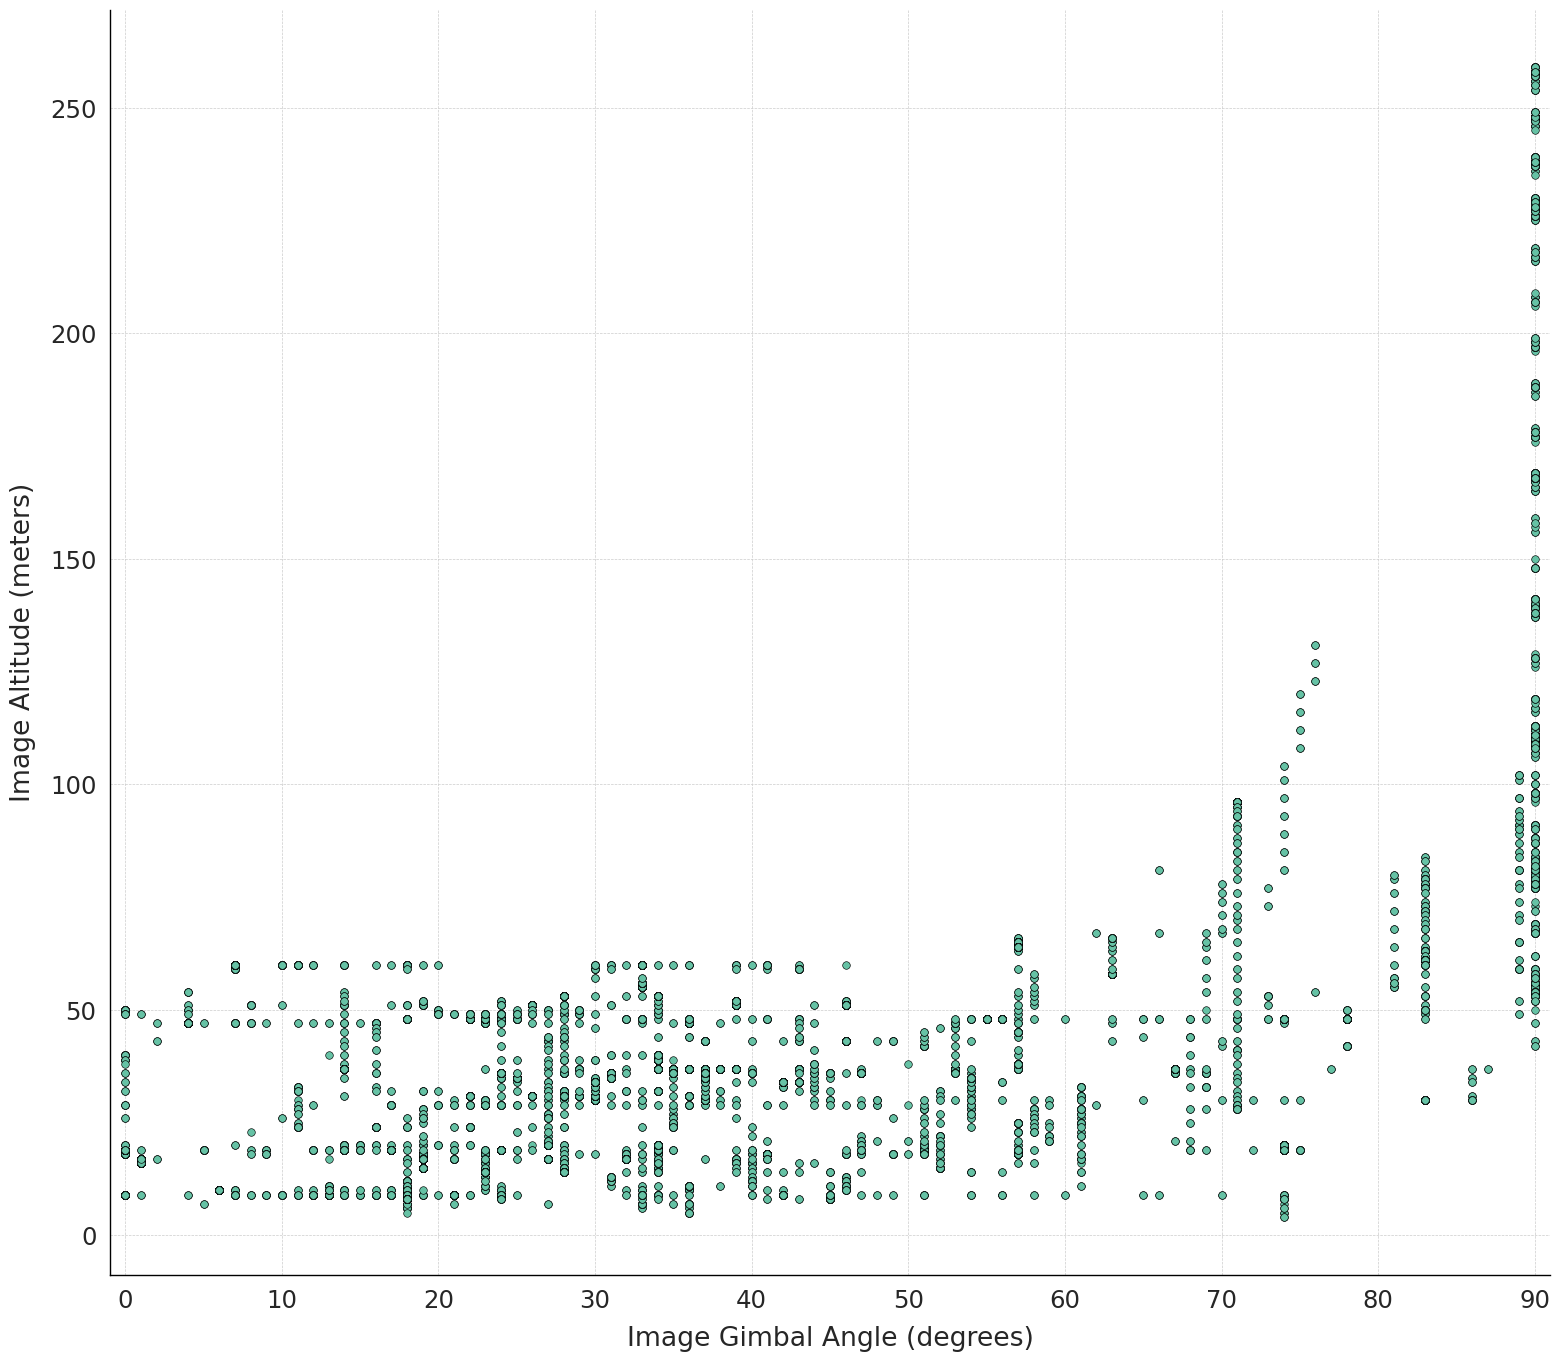

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

angle_list = angle_list_val + angle_list_train + angle_list_test
height_list = height_list_val + height_list_train + height_list_test
sns.set(style="whitegrid", font_scale=1.6, rc={"axes.edgecolor": "black", "axes.linewidth": 1})
sns.set_palette("Set2")

_, ax = plt.subplots(figsize=(16, 14))

ax.set_xlabel("Image Gimbal Angle (degrees)", labelpad=10)
ax.set_ylabel("Image Altitude (meters)", labelpad=10)

# Create the scatter plot
sns.scatterplot(x=angle_list, y=height_list, s=30, alpha=1, edgecolor='black')

# Set x-axis limits
plt.xlim(-1, 91)

# Set x-axis ticks
plt.xticks(range(0, 91, 10))

# Adjust plot aesthetics
sns.despine()  # Remove the top and right spines
plt.grid(True, linestyle='--', linewidth=0.5)  # Add grid lines
plt.tight_layout()  # Adjust spacing

# Save the plot
#plt.savefig('./scatteranglealtitude.png', dpi=300)

# Show the plot
plt.show()
